# pytorch_VAE.ipynb
# WESmith 07/15/23
## Variational Autoencoder (VAE)
## reference:
## https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torchsummary import summary

In [2]:
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [3]:
transform = transforms.ToTensor()

In [53]:
batch_size       = 64
lr               = 1e-3
decay            = 1e-5
data_dir         = 'data'
model_path       = 'results/model_VAE.pth'
optimizer_path   = 'results/optimizer_VAE.pth'
model_path_2     = 'results/model_VAE_2.pth'      # WS mods to model
optimizer_path_2 = 'results/optimizer_VAE_2.pth'

In [5]:
mnist_data = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

In [101]:
# get a data batch for demonstrations
dataiter = iter(data_loader)
images, labels = next(dataiter)

In [8]:
images.shape

torch.Size([64, 1, 28, 28])

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

In [10]:
class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),)    

        self.z_mean    = nn.Linear(3136, 2)
        self.z_log_var = nn.Linear(3136, 2)

        self.decoder = nn.Sequential(
                nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid())
        
    def reparameterize(self, z_mu, z_log_var):
        #eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [43]:
class VAE2(nn.Module):  # WS mod to increase autoencoding layer size

    def __init__(self, encode_size):  # WS mod
        super().__init__()
        self.encode_size = encode_size  # WS mod

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),)    

        self.z_mean    = nn.Linear(3136, encode_size)  # WS mod
        self.z_log_var = nn.Linear(3136, encode_size)  # WS mod

        self.decoder = nn.Sequential(
                nn.Linear(encode_size, 3136),  # WS mod
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid())

    def reparameterize(self, z_mu, z_log_var):
        #eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded    

In [102]:
def train(model, optimizer, loss_fn, data_loader, n_epochs=1, save=False):
    # 'save' is a tuple of (model_path, optimizer_path), default=False
    for epoch in range(n_epochs):
        for (img, _) in data_loader:

            encoded, z_mean, z_log_var, decoded = model(img)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                        - z_mean**2 
                                        - torch.exp(z_log_var), 
                                          axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div    = kl_div.mean() # average over batch dimension

            pixel_term = loss_fn(decoded, img, reduction='none')
            pixel_term = pixel_term.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixel_term = pixel_term.mean() # average over batch dimension

            loss = pixel_term + kl_div

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')
        if save:
            torch.save(model.state_dict(),     save[0])
            torch.save(optimizer.state_dict(), save[1])

In [116]:
def train_or_load(model, optimizer, load, loss_fn=None, data_loader=None, n_epochs=1):
    # 'load' is a tuple of (model_path, optimizer_path)
    if os.path.isfile(load[0]) and os.path.isfile(load[1]):
        model_state_dict = torch.load(load[0])
        model.load_state_dict(model_state_dict)
        optimizer_state_dict = torch.load(load[1])
        optimizer.load_state_dict(optimizer_state_dict)
    else:
        train(model, optimizer, loss_fn, data_loader, n_epochs=n_epochs, save=load)

In [103]:
def examine_loss(model, data):
    '''convenience function to look at loss from a batch of data for a given model'''
    encoded, z_mean, z_log_var, decoded = model(data)
    print(f'LOSS over batch size of {data.shape[0]}: {loss_fn(data, decoded):.5f}')

## ORIGINAL MODEL WITH ENCODING SIZE FIXED AT 2

In [117]:
model_path     = 'results/model_VAE.pth'
optimizer_path = 'results/optimizer_VAE.pth'
model          = VAE()
loss_fn        = F.mse_loss
optimizer      = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

In [121]:
sum(k.numel() for k in model.parameters())

207237

In [118]:
examine_loss(model, images)  # loss before training

LOSS over batch size of 64: 0.28088


In [119]:
train_or_load(model, optimizer, (model_path, optimizer_path))

In [120]:
examine_loss(model, images)  # loss after training

LOSS over batch size of 64: 0.04516


In [18]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=3136, out_features=2, bias=True)
  (z_log_var): Linear(in_features=3136, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspos

In [21]:
summary(model, images.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
           Flatten-8                 [-1, 3136]               0
            Linear-9                    [-1, 2]           6,274
           Linear-10                    [-1, 2]           6,274
           Linear-11                 [-1, 3136]           9,408
          Reshape-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13             [-1, 64, 7, 7]          36,928
        LeakyReLU-14             [-1, 6

## NEW MODEL WITH VARIABLE ENCODING SIZE

In [122]:
encode_size      = 8  # was 2 in original model
model_path_2     = f'results/model_VAE_{encode_size}.pth'      # WS mods to model
optimizer_path_2 = f'results/optimizer_VAE_{encode_size}.pth'
model2           = VAE2(encode_size)
optimizer2       = optim.Adam(model2.parameters(), lr=lr, weight_decay=decay)

In [125]:
model_path_2, optimizer_path_2

('results/model_VAE_8.pth', 'results/optimizer_VAE_8.pth')

In [123]:
sum(k.numel() for k in model2.parameters())

263697

In [126]:
examine_loss(model2, images) # loss before training

LOSS over batch size of 64: 0.17499


In [128]:
load = (model_path_2, optimizer_path_2)
train_or_load(model2, optimizer2, load, loss_fn=loss_fn, data_loader=data_loader)

Epoch: 1, Loss: 30.1986


In [129]:
examine_loss(model2, images) # loss after training

LOSS over batch size of 64: 0.02813


## EXAMINE ORIGINAL, DECODED, ENCODED (FOR 2D ENCODING) 

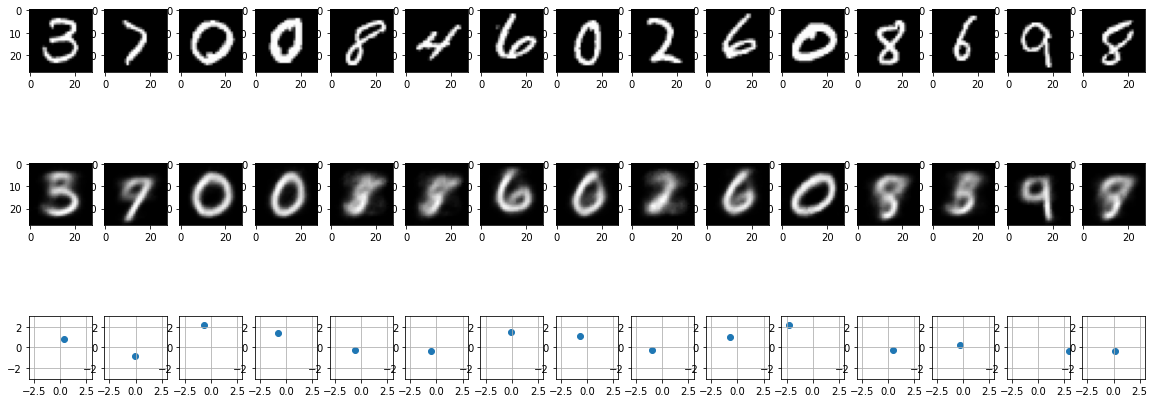

In [100]:
encoded, z_mean, z_log_var, decoded = model(images)
nc  = 15
lim = 3
plt.figure(figsize=(20,8))
plt.gray()
for i, item in enumerate(images):
    if i >= nc: break
    plt.subplot(3, nc, i+1)
    #item = item.reshape(-1, 28, 28)
    # item is (1, 28, 28) with singleton from data_loader
    plt.imshow(item[0])

for i, item in enumerate(decoded):
    if i >= nc: break
    plt.subplot(3, nc, nc+i+1)
    #item = item.reshape(-1, 28, 28)
    plt.imshow(item[0].detach().numpy()) # also a singleton, so take [0]
    
for i, item in enumerate(encoded):
    if i >= nc: break
    plt.subplot(3, nc, 2*nc+i+1)
    val = item.detach().numpy()
    plt.scatter(val[0], val[1])
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()

## EXAMINE DECODED FROM LINEAR SCAN OF 2D ENCODING

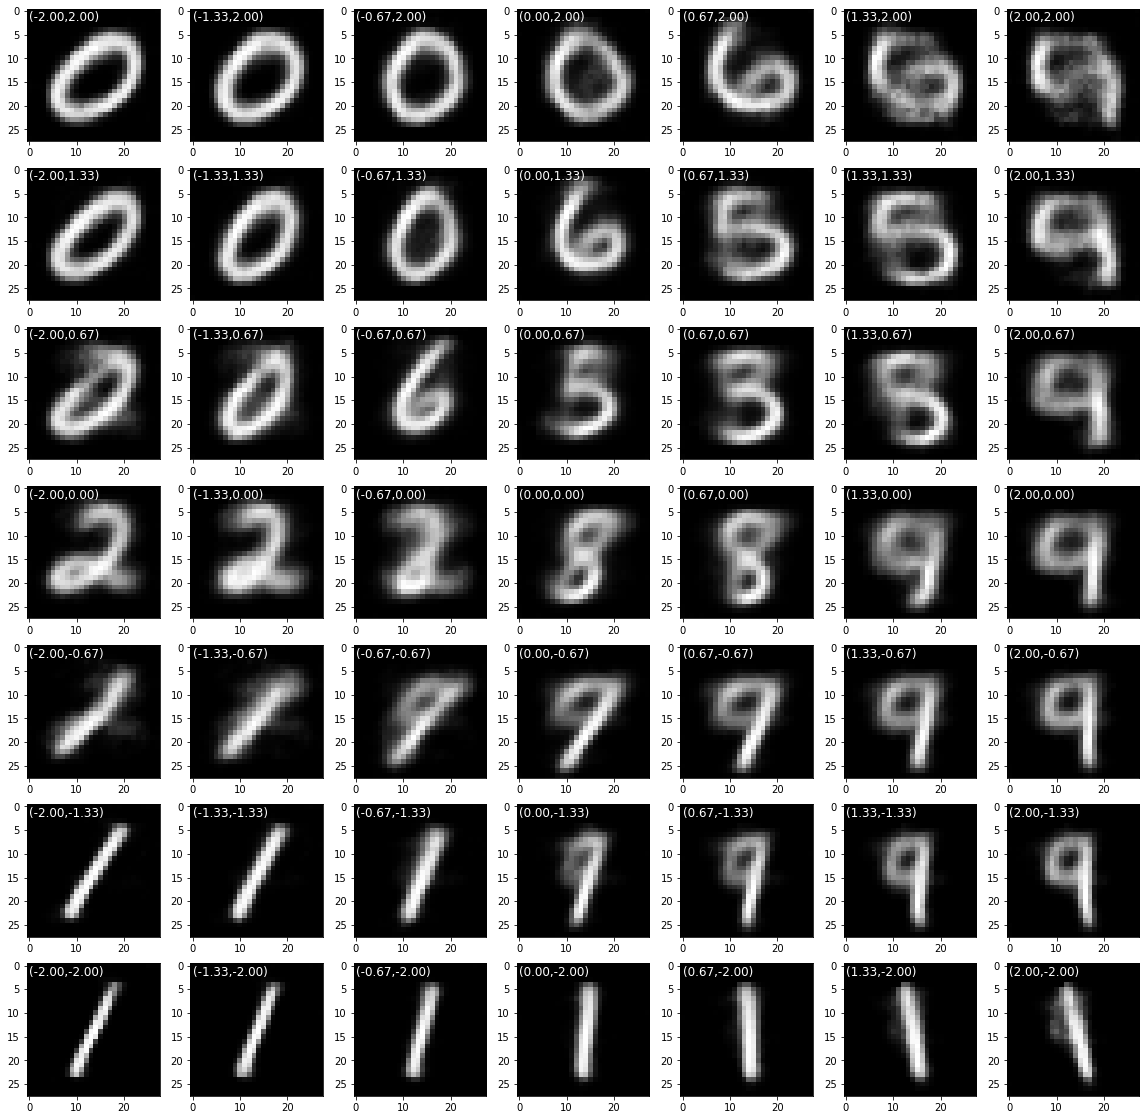

In [58]:
nr, nc = (7, 7)
lim = 2
plt.figure(figsize=(20,20))
plt.gray()
count = 1
for y in np.linspace(lim, -lim, num=nr):
    for x in np.linspace(-lim, lim, num=nc):
        dd = model.decoder(torch.tensor((x, y), dtype=torch.float32))
        plt.subplot(nr, nc, count)
        txt = f'({x:.2f},{y:.2f})'
        plt.imshow(dd[0][0].detach().numpy())
        plt.text(0, 0, txt, va='top', color='white', fontsize=12)
        count += 1